# Pairs Trading using Sig Trader

Context: we have a universe with $d=2$ stocks and we assume that although both assets have their own underlying dynamics, their joint behavior should hold some predictability. For the sake of simplicity, in this notebook we will assume that the spread between the two assets is mean-reverting. The more general approach to pairs trading isn't much more complicated.

In theory, a simple Order 1 Sig Trader can already capture the mean-reverting dynamic in pairs trading. Indeed, since we have no outside information $f_t$, our market factor process is simply $\hat{Z}_t=(t,X_t,Y_t)$ where $X_t$ is our first asset and $Y_t$ our second asset. Therefore the $1$-truncated signature of the stopped process $(\hat{Z}_s)_{0\leq s \leq t}$ reads:

$$\hat{\mathbb{Z}}_{0,t}^{\leq 1}=\bigg(1,
\begin{bmatrix}
t \\ X_t-X_0 \\ Y_t-Y_0
\end{bmatrix}\bigg)$$

Therefore, an Order 1 Sig Trader could easily learn to rebuild the spread $Y_t-X_t$ using signature terms given that
$\langle \ell, \mathbb{Z}_{0,t}^{\leq 1} \rangle = \ell^0 \cdot 1 + \ell^1 \cdot t + \ell^2 \cdot (X_t-X_0) + \ell^3 \cdot (Y_t-Y_0)$, and thus it could set $\xi_t^1 \propto Y_t-X_t$ and $\xi_t^2 \propto X_t-Y_t$, effectively defining a mean-reversion strategy.

Note that in order to capture the spread, i.e. in order to have $\langle \ell, \mathbb{Z}_{0,t}^{\leq 1} \rangle \propto X_t-Y_t$, we must have 
- $\ell^0\simeq 0$ because there is no needed to recenter the spread $(X_t-X_0) - (Y_t-Y_0)$ since we have $X_0=Y_0$
- $\ell^1\simeq 0$ since time doesn't matter (we model stationary processes)
- $\ell^2 \simeq - \ell^3$ since we want to capture the spread. The absolute magnitude of these two terms will determine the size of the positions we take and therefore will depend on the variance criterion $\Delta$ of the Sig Trader

### 0. Import libraries

In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

### 1. Define some utils

In [2]:
def generate_synthetic_pairs(batch_size: int, T: int, delta_t: float, X_0: float, Y_0: float, sigma_x: float, sigma_y: float, kappa: float) -> torch.Tensor:
    """
    Generate synthetic pairs of stock prices using the Ornstein-Uhlenbeck process. (additive model)
    :param batch_size: number of pairs to generate
    :param T: time horizon (in years)
    :param freq: frequency of price updates
    :param X_0: initial price of the first stock
    :param Y_0: initial price of the second stock
    :param sigma_x: (annual) volatility of the first stock
    :param sigma_y: (annual) volatility of the second stock
    :param kappa: mean reversion rate
    :return: a tensor of shape (batch_size, n, 2) containing the price paths of the two stocks
    """
    # we use the additive model instead of the multiplicative model (as proposed in the paper)
    n_assets = 2
    n_points = int(T/delta_t)
    price_paths = torch.zeros(batch_size, n_points, n_assets)
    price_paths[:,:,0] = X_0
    price_paths[:,:,1] = Y_0

    for i in range(1,n_points):
        # # additive model
        # price_paths[:,i,0] = price_paths[:,i-1,0] + sigma_x*torch.randn(batch_size)*np.sqrt(delta_t)
        # price_paths[:,i,1] = price_paths[:,i-1,1] + sigma_y*torch.randn(batch_size)*np.sqrt(delta_t) + kappa*(price_paths[:,i-1,0] - price_paths[:,i-1,1])*delta_t

        # multiplicative model
        price_paths[:,i,0] = price_paths[:,i-1,0] + sigma_x*torch.randn(batch_size)*np.sqrt(delta_t)*price_paths[:,i-1,0]
        price_paths[:,i,1] = price_paths[:,i-1,1] + sigma_y*torch.randn(batch_size)*np.sqrt(delta_t)*price_paths[:,i-1,1] + kappa*(price_paths[:,i-1,0] - price_paths[:,i-1,1])*delta_t
        
    return price_paths

### 2. Generate synthetic data

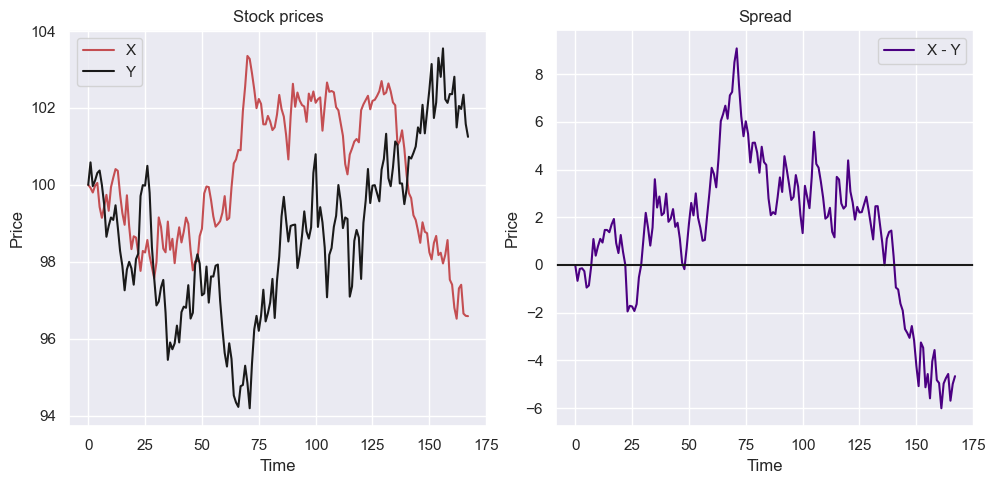

In [3]:
# Pairs Trading parameters
sigma_x = 0.2
sigma_y = 0.3
kappa = 50
freq = 252*8 # hourly data
delta_t = 1/freq # time between two points in the time series
n_years = 1/12 # 1 month of data
X_0 = 100
Y_0 = 100

batch_size = 1000 # number of pairs to generate (the more the better for the Sig Trader to learn)
price_paths = generate_synthetic_pairs(batch_size, n_years, delta_t, X_0, Y_0, sigma_x, sigma_y, kappa)
n_points = price_paths.shape[1] # number of points in each time series

info_data = torch.zeros((batch_size, n_points, 0)) # no info data

# plot the prices of an arbitrary pair in the batch
sample_index = 0
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(price_paths[sample_index,:,0], label="X", color='r')
axs[0].plot(price_paths[sample_index,:,1], label="Y" , color='k')
axs[0].set_title("Stock prices")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Price")
axs[0].legend()

axs[1].plot(price_paths[sample_index,:,0] - price_paths[sample_index,:,1], label="X - Y", color='indigo')
axs[1].axhline(y=0, color='k')
axs[1].set_title("Spread")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Price")
axs[1].legend()

plt.tight_layout()
plt.show()

### 3. Fit Order 1 Sig Trader

In [4]:
# Sig Trader parameters
depth = 1
delta = 1 # variance criterion, not very important (simply rescale the positions xi)
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(price_paths, info_data)
ts.print_functionals()

function compute_signature took 1.17s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

L_1
Level 0:
tensor([-0.0105])
Level 1:
tensor([-0.0035,  0.0772, -0.0801])
L_2
Level 0:
tensor([-0.1137])
Level 1:
tensor([ 0.1165, -0.0844,  0.1013])


In [5]:
# fit with only 1000 samples
n_samples = 1000
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[:n_samples,:,:], info_data[:n_samples,:,:])
ts.print_functionals()

NameError: name 'synthetic_batch_stock_data' is not defined

In [ ]:
# fit with only 1000 samples
n_samples = 10000
print('first 1/3 of the data')
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[:n_samples,:,:], info_data[:n_samples,:,:])
ts.print_functionals()

print('second 1/3 of the data')
shift = 10000
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[shift:shift+n_samples,:,:], info_data[shift:shift+n_samples,:,:])
ts.print_functionals()

print('last 1/3 of the data')
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[2*shift:2*shift+n_samples,:,:], info_data[2*shift:2*shift+n_samples,:,:])
ts.print_functionals()

first 1/3 of the data
function compute_signature took 9.30s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

l1:
Level 0:
tensor([-0.5919])
Level 1:
tensor([   1.0878,  766.8914, -808.5336])


l2:
Level 0:
tensor([0.6794])
Level 1:
tensor([-6.6805e-01, -8.1321e+02,  9.1429e+02])
second 1/3 of the data
function compute_signature took 9.12s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

l1:
Level 0:
tensor([0.7499])
Level 1:
tensor([  -0.9143,  752.8684, -782.3273])


l2:
Level 0:
tensor([-0.9131])
Level 1:
tensor([   0.9491, -792.5998,  889.3889])
last 1/3 of the data
function compute_signature took 10.89s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

l1:
Level 0:
tensor([1.0461])
Level 1:
tensor([  -1.0899,  751.6472, -798.6096])


l2:
Level 0:
tensor([-1.0581])
Level 1:
tensor([   0.9874, -812.666

In [ ]:
# train on all data
print('all data')
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data, info_data)
ts.print_functionals()

all data
function compute_signature took 27.93s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

l1:
Level 0:
tensor([0.3911])
Level 1:
tensor([-2.9643e-01,  7.5697e+02, -7.9626e+02])


l2:
Level 0:
tensor([-0.4122])
Level 1:
tensor([ 4.0478e-01, -8.0581e+02,  9.0971e+02])


In [ ]:
# FLIP THEM!
ts.functionals[0] = -ts.functionals[0]
ts.functionals[1] = -ts.functionals[1]

## Trading on in-sample data

In [ ]:
n_traded_processes = 20 # we trade 20 pairs (uncorrelated!)
all_daily_pnl = torch.zeros(n_traded_processes, n-1)
all_cum_pnl = torch.zeros(n_traded_processes, n-1)
for i in range(n_traded_processes):
    X = synthetic_batch_stock_data[i,:,:]
    f = info_data[i,:,:]
    xi = ts.trade(X, f)
    daily_pnl = ts.compute_pnl(X, xi) # daily pnl on each asset
    daily_global_pnl = torch.sum(daily_pnl, dim=1) # daily pnl on the portfolio
    cum_global_pnl = torch.cumsum(daily_global_pnl, dim=0)
    all_daily_pnl[i,:] = daily_global_pnl
    all_cum_pnl[i,:] = cum_global_pnl

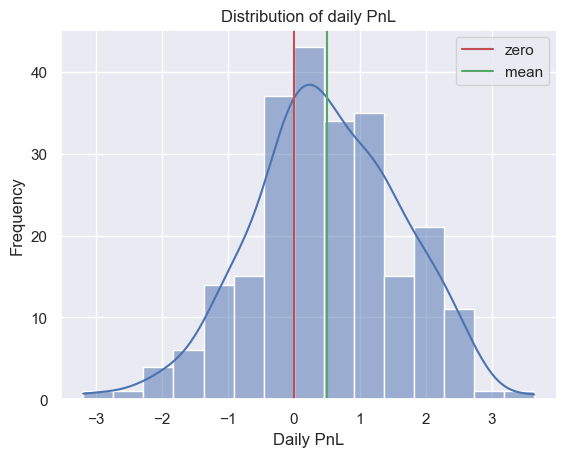

In [ ]:
# dist of all daily pnl
daily_portfolio_pnl = torch.sum(all_daily_pnl, dim=0)
sns.histplot(daily_portfolio_pnl, kde=True)
plt.title("Distribution of daily PnL")
plt.xlabel("Daily PnL")
plt.ylabel("Frequency")
plt.axvline(x=0, color='r', linestyle='-', label='zero')
mean_daily_pnl = torch.mean(daily_portfolio_pnl)
plt.axvline(x=mean_daily_pnl, color='g', linestyle='-', label='mean')
plt.legend()
plt.show()

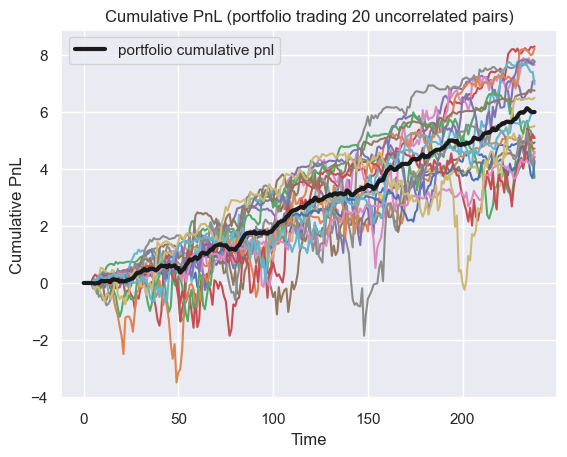

In [ ]:
# plot all cumulative pnl paths
plt.title(f"Cumulative PnL (portfolio trading {n_traded_processes} uncorrelated pairs)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.plot(all_cum_pnl.T)
mean_cum_pnl = torch.mean(all_cum_pnl, dim=0)
plt.plot(mean_cum_pnl, color='k', linewidth=3, label='portfolio cumulative pnl')
plt.legend()
plt.show()

In [ ]:
daily_portfolio_pnl.mean()

tensor(0.5010)

In [ ]:
avg_daily_pnl = daily_portfolio_pnl.mean()
std_daily_pnl = daily_portfolio_pnl.std()
sharpe_ratio = avg_daily_pnl/std_daily_pnl * np.sqrt(252)
print(f"Sharpe ratio: {sharpe_ratio}")
print('NO SHARPE')

Sharpe ratio: 7.132180690765381
NO SHARPE


In [ ]:
# OUT OF SAMPLE

# generate new data
batch_size = 20
oos_stock_data = generate_synthetic_pairs(batch_size, T, n, X_0, Y_0, sigma_x, sigma_y, kappa)
info_data = torch.zeros(batch_size, n, 0) # no info

# trade on new data
n_traded_processes = batch_size
all_daily_pnl = torch.zeros(n_traded_processes, n-1)
all_cum_pnl = torch.zeros(n_traded_processes, n-1)
for i in range(n_traded_processes):
    X = oos_stock_data[i,:,:]
    f = info_data[i,:,:]
    xi = ts.trade(X, f)
    daily_pnl = ts.compute_pnl(X, xi) # daily pnl on each asset
    daily_global_pnl = torch.sum(daily_pnl, dim=1) # daily pnl on the portfolio
    cum_global_pnl = torch.cumsum(daily_global_pnl, dim=0)
    all_daily_pnl[i,:] = daily_global_pnl
    all_cum_pnl[i,:] = cum_global_pnl

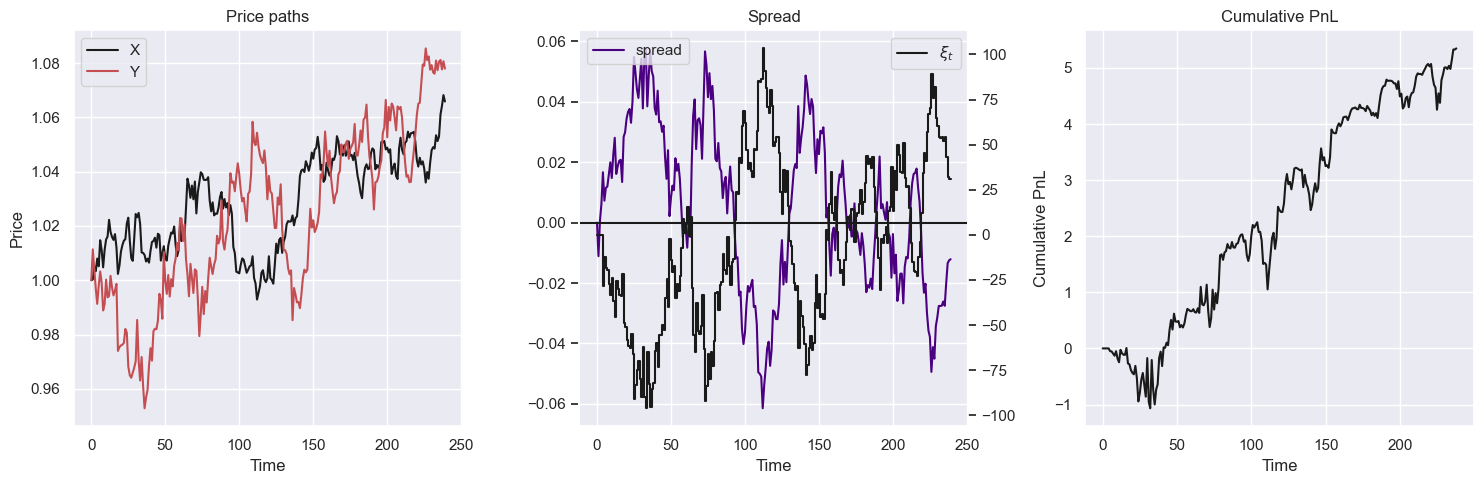

In [ ]:
# example of one pnl path
index = 0
X = oos_stock_data[index,:,:]
f = info_data[index,:,:]
xi = ts.trade(X, f)
daily_pnl = ts.compute_pnl(X, xi) # daily pnl on each asset
cum_pnl = torch.cumsum(daily_pnl, dim=0)
cum_pnl_both = torch.sum(cum_pnl, dim=1)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(X[:,0], color='k')
ax[0].plot(X[:,1], color='r')
ax[0].set_title("Price paths")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Price")
ax[0].legend(["X", "Y"])

ax[1].plot(X[:,0] - X[:,1], color='indigo', label='spread')
ax[1].axhline(y=0, color='k', linestyle='-')
ax[1].set_xlabel("Time")
ax[1].legend(loc='upper left')
ax[1] = ax[1].twinx()
ax[1].step(np.arange(n), xi[:,0]-xi[:,1], color='k', label=r'$\xi_t$')
ax[1].set_title("Spread")
ax[1].set_xlabel("Time")
ax[1].grid(False)
ax[1].legend()

ax[2].plot(cum_pnl_both, color='k')
ax[2].set_title("Cumulative PnL")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Cumulative PnL")

plt.tight_layout()
plt.show()

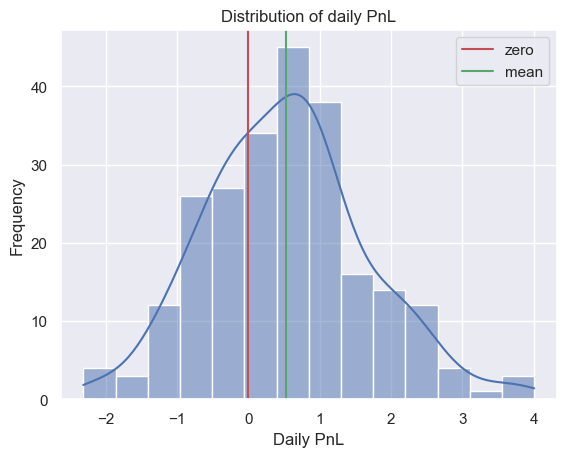

In [ ]:
# dist of all daily pnl
daily_portfolio_pnl = torch.sum(all_daily_pnl, dim=0)
sns.histplot(daily_portfolio_pnl, kde=True)
plt.title("Distribution of daily PnL")
plt.xlabel("Daily PnL")
plt.ylabel("Frequency")
plt.axvline(x=0, color='r', linestyle='-', label='zero')
mean_daily_pnl = torch.mean(daily_portfolio_pnl)
plt.axvline(x=mean_daily_pnl, color='g', linestyle='-', label='mean')
plt.legend()
plt.show()

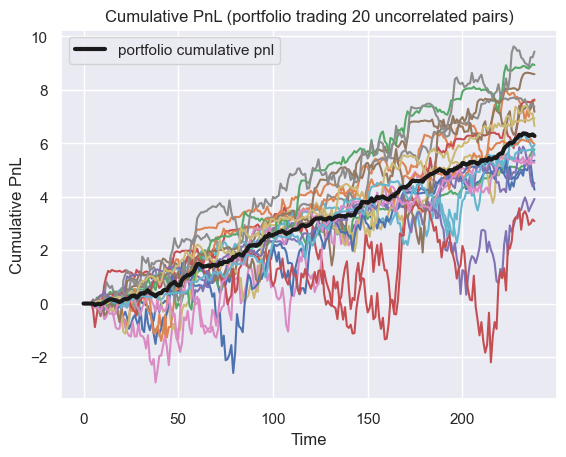

In [ ]:
# plot all cumulative pnl paths
plt.title(f"Cumulative PnL (portfolio trading {n_traded_processes} uncorrelated pairs)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.plot(all_cum_pnl.T)
mean_cum_pnl = torch.mean(all_cum_pnl, dim=0)
plt.plot(mean_cum_pnl, color='k', linewidth=3, label='portfolio cumulative pnl')
plt.legend()
plt.show()

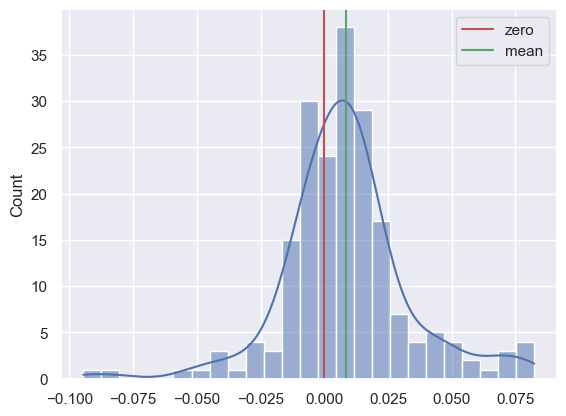

In [ ]:
mean_cum_pnl_np = mean_cum_pnl.detach().numpy()
min_steps = 10
portfolio_returns = mean_cum_pnl_np[1+min_steps:]/mean_cum_pnl_np[min_steps:-1] - 1
# drop values that are too large
portfolio_returns = portfolio_returns[portfolio_returns < 0.1]
portfolio_returns = portfolio_returns[portfolio_returns > -0.1]
sns.histplot(portfolio_returns, kde=True)
plt.axvline(x=0, color='r', linestyle='-', label='zero')
mean_portfolio_returns = np.mean(portfolio_returns)
plt.axvline(x=mean_portfolio_returns, color='g', linestyle='-', label='mean')
plt.legend()
plt.show()

In [ ]:
avg_daily_pnl = daily_portfolio_pnl.mean()
std_daily_pnl = daily_portfolio_pnl.std()
sharpe_ratio = avg_daily_pnl/std_daily_pnl * np.sqrt(252)
print(f"Sharpe ratio: {sharpe_ratio}")

Sharpe ratio: 7.427604675292969
